In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use("seaborn")
from tqdm import tqdm
import time
from typing import List, Set, Dict, Tuple, Optional, Callable, Iterator, Union
import math
import pyLDAvis
import pyLDAvis.sklearn as LDAsklearn
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel

from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.min_rows', 50)

## Fonctions

In [135]:
class Model:
    def __init__(self, y_train: np.ndarray, y_test: np.ndarray, scoring: Optional[str] = None, prop_tags: Union[str, int] = 'origin'):
        self.models = pd.DataFrame(columns=[
            'name',
            'data_use',
            'model',
            'confusion_matrice',
            'Error',
            'Jaccard Macro',
            'Precision Macro',
            'Recall Macro',
            'F_mesure Macro',
            'auc Macro',
            'Jaccard Micro',
            'Precision Micro',
            'Recall Micro',
            'F_mesure Micro',
            'auc Micro',
            'proportion_de_prédiction',
            'fit_time',
            'pred_time',
            'y_pred',
            'best_params',
            'grid_params',
            'grid_score',
            'params'
        ])
        self.scoring = scoring
        self.prop_tags = prop_tags
        self.models.set_index('name', inplace=True)
        self.y_train = y_train
        self.y_test = y_test
        self.x = {}
    def add_model(self, name: str, model, params=None):
        """
        Effectue une recherche par grille sur les paramètres.
        """
        self.models.loc[name, 'grid_params'] = params
        self.models.loc[name, 'model'] = model
    def add_prediction(self, name: str, y_pred: np.ndarray, fit_time: float = 0, pred_time: float = 0):
        """
        ajout des données prédite (utilisé pour les models non supervisé).
        """
        self.models.loc[name, 'y_pred'] = y_pred
        self.models.loc[name, 'fit_time'] = fit_time
        self.models.loc[name, 'pred_time'] = pred_time
    def add_data(self, name: str, x_train, x_test):
        self.x[name] = {
            'x_train': x_train,
            'x_test': x_test
        }
    def fit(self, name='all', data_name=None, cv: Optional[int] = None):
        if name == 'all':
            self.models.apply(lambda x: self._fit_process(x, data_name, cv), axis=1)
        elif type(name) == str:
            self._fit_process(self.models.loc[name], data_name, cv)
        elif type(name) == list:
            for model_name in name:
                self._fit_process(self.models.loc[model_name], data_name, cv)
    def _fit_process(self, model: pd.Series, data_name: str, cv: Optional[int]):
        if data_name == None:
            data_name = list(self.x.keys())[-1]
        x_train = self.x[data_name]['x_train']
        x_test = self.x[data_name]['x_test']
        if model['grid_params'] != None:
            grid = GridSearchCV(model['model'], model['grid_params'], n_jobs=-1, cv=cv, scoring=self.scoring, verbose=3)
            grid.fit(x_train, self.y_train)
            model['grid_score'] = {
                'mean_test_score': grid.cv_results_['mean_test_score'],
                'mean_fit_time': grid.cv_results_['mean_fit_time'],
                'mean_score_time': grid.cv_results_['mean_score_time'],
                'params': grid.cv_results_['params']
            }
            model['model'] = grid.best_estimator_
        start = time.time()
        model['model'].fit(x_train, self.y_train)
        stop = time.time()
        print('le model '+model.name+' à fini son entrainement')
        model['fit_time'] = stop - start
        model['best_params'] = model['model'].get_params()
        model['data_use'] = data_name
        start = time.time()
        y_pred = np.array(model['model'].predict_proba(x_test))[:,:,1].T
        stop = time.time()
        model['pred_time'] = stop - start
        model['y_pred'] = y_pred
        self.compute_perf(model.name)
        print('tout est bon pour le model '+model.name)
    def compute_perf(self, model_name: str, prop_tags: Optional[Union[str, int]] = None):
        model: pd.Series = self.models.loc[model_name]
        y_true: np.ndarray = self.y_test
        y_pred: np.ndarray = model['y_pred']
        n_classes = y_true.shape[1]
        n_indiv = y_true.shape[0]
        if not prop_tags :
            prop_tags = self.prop_tags
        if prop_tags == 'origin':
            prop_tags = y_true.sum()/n_indiv
        i = 0.5
        seuil = 1
        while i > 0.005 :
            if (y_pred >= seuil).sum()/n_indiv < prop_tags :
                seuil -= i
            else :
                seuil += i
            i /= 2
        y_predict = y_pred >= seuil
        mcm = metrics.multilabel_confusion_matrix(y_true, y_predict)
        tn = mcm[:, 0, 0].mean()
        tp = mcm[:, 1, 1].mean()
        fn = mcm[:, 1, 0].mean()
        fp = mcm[:, 0, 1].mean()
        model['confusion_matrice'] = [[tn, fn], [fp, tp]]
        model['Error'] = metrics.hamming_loss(y_test, y_predict)
        model['Jaccard Macro'] = metrics.jaccard_score(y_test, y_predict, average='macro')
        model['Precision Macro'] = metrics.precision_score(y_test, y_predict, average='macro')
        model['Recall Macro'] = metrics.recall_score(y_test, y_predict, average='macro')
        model['F_mesure Macro'] = metrics.f1_score(y_test, y_predict, average='macro')
        model['Jaccard Micro'] = metrics.jaccard_score(y_test, y_predict, average='micro')
        model['Precision Micro'] = metrics.precision_score(y_test, y_predict, average='micro')
        model['Recall Micro'] = metrics.recall_score(y_test, y_predict, average='micro')
        model['F_mesure Micro'] = metrics.f1_score(y_test, y_predict, average='micro')
        model['proportion_de_prédiction'] = (tp + fp)/(tp + fn)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = metrics.roc_curve(y_true[:, i], y_pred[:, i])
            if y_true[:, i].sum() == 0:
                tpr[i] = fpr[i]
            roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        precision, recall, _ = metrics.precision_recall_curve(y_true.ravel(), y_pred.ravel())
        
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_true.ravel(), y_pred.ravel())
        roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
        
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes
            
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
        
        model['auc Micro'] = roc_auc["micro"]
        model['auc Macro'] = roc_auc["macro"]
        model['params'] = {
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc,
            'precision': precision,
            'recall': recall
        }
    def plot_roc(self, model_list: list = [], plot_size: int = 10):
        if model_list == []:
            model_list = self.models.index.to_list()
        lenth = len(model_list)
        sqrt = math.floor(math.sqrt(lenth))
        plt.figure(figsize=(plot_size*sqrt,plot_size*math.ceil(lenth/sqrt)))
        for it, name in enumerate(model_list):
            plt.subplot(math.ceil(lenth/sqrt), sqrt, it+1)
            model = self.models.loc[name]
            fpr = model['params']['fpr']
            tpr = model['params']['tpr']
            roc_auc = model['params']['roc_auc']
            plt.plot(
                fpr["micro"],
                tpr["micro"],
                label="micro-average Courbe ROC (surface = {0:0.2f})".format(roc_auc["micro"])
            )
            plt.plot(
                fpr["macro"],
                tpr["macro"],
                label="macro-average Courbe ROC (surface = {0:0.2f})".format(roc_auc["macro"])
            )
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.xlabel("Ratio Faux Positif", fontsize=14)
            plt.ylabel("Ratio Vrais Positif", fontsize=14)
            plt.title("Courbe ROC du model : "+ name, fontsize=16)
            plt.legend(loc="lower right", fontsize=12)
        plt.show()
    def plot_precision_recall(self, model_list: list = [], plot_size: int = 10):
        if model_list == []:
            model_list = self.models.index.to_list()
        lenth = len(model_list)
        sqrt = math.floor(math.sqrt(lenth))
        plt.figure(figsize=(plot_size*sqrt,plot_size*math.ceil(lenth/sqrt)))
        for it, name in enumerate(model_list):
            plt.subplot(math.ceil(lenth/sqrt), sqrt, it+1)
            model = self.models.loc[name]
            precision = model['params']['precision']
            recall = model['params']['recall']
            plt.plot(
                precision,
                recall
            )
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.xlabel("Précision", fontsize=14)
            plt.ylabel("Recall", fontsize=14)
            plt.title("Courbe Précision Recall du model : "+ name, fontsize=16)
        plt.show()
            
    def plot_perf(self, perf_list: List[str] = [], plot_size: int = 10, model_list: List = []):
        if perf_list == []:
            perf_list = ['Error', 'Jaccard Macro', 'Precision Macro',
                        'Recall Macro', 'F_mesure Macro', 'auc Macro',
                        'Jaccard Micro', 'Precision Micro', 'Recall Micro',
                        'F_mesure Micro', 'auc Micro', 'proportion_de_prédiction',
                        'fit_time', 'pred_time']
        if model_list == []:
            models = self.models
        else:
            models = self.models.loc[model_list]
        lenth = len(perf_list)
        sqrt = math.floor(math.sqrt(lenth))
        plt.figure(figsize=(plot_size*sqrt,plot_size*math.ceil(lenth/sqrt)))
        for it, score in enumerate(perf_list):
            plt.subplot(math.ceil(lenth/sqrt), sqrt, it+1)
            value = self.models[score].values.astype('float')
            colors = cm.plasma_r(value / float(max(value)))
            plt.bar(self.models.index, value, color = colors)
            plt.title('Score '+score+' par Modele', fontsize=16)
            plt.xticks(rotation=30, fontsize=14)
            plt.yticks(fontsize=16)
            plt.xlabel('')
            plt.ylabel(score, fontsize=14)
        plt.show()
    def plot_grid(self, model_name: str, plot_height: int = 10, model_lenth: float = 1.5):
        model = self.models.loc[model_name]
        params = []
        val = ''
        for param_list in model['grid_score']['params']:
            for param in param_list.keys():
                val+= str(param) + ': ' +str(param_list[param]) + '\n'
            params.append(val)
            val = ''
        plt.figure(figsize=(model_lenth*len(params), plot_height*3))
        plt.subplot(311)
        value = model['grid_score']['mean_test_score']
        colors = cm.plasma_r(value / float(max(value)))
        plt.bar(params, value, color = colors)
        plt.title('Score moyen par paramètre', fontsize=16)
        plt.xticks(rotation=30, fontsize=14)
        plt.yticks(fontsize=16)
        plt.xlabel('')
        plt.ylabel('score moyen des folds', fontsize=14)
        
        plt.subplot(312)
        value = model['grid_score']['mean_fit_time']
        colors = cm.plasma_r(value / float(max(value)))
        plt.bar(params, value, color = colors)
        plt.title('temp d\'entrainement par paramètre', fontsize=16)
        plt.xticks(rotation=30, fontsize=14)
        plt.yticks(fontsize=16)
        plt.xlabel('')
        plt.ylabel('score moyen des folds', fontsize=14)
        
        plt.subplot(313)
        value = model['grid_score']['mean_score_time']
        colors = cm.plasma_r(value / float(max(value)))
        plt.bar(params, value, color = colors)
        plt.title('temp de prédiction par paramètre', fontsize=16)
        plt.xticks(rotation=30, fontsize=14)
        plt.yticks(fontsize=16)
        plt.xlabel('')
        plt.ylabel('score moyen des folds', fontsize=14)
        plt.show

In [4]:
def plot_perf(perf_list: list, plot_size: int = 10):
    lenth = len(perf_list)
    sqrt = math.floor(math.sqrt(lenth))
    plt.figure(figsize=(plot_size*sqrt,plot_size*math.ceil(lenth/sqrt)))
    for it, score in enumerate(perf_list):
        plt.subplot(math.ceil(lenth/sqrt), sqrt, it+1)
        value = models.models[score].values.astype('float')
        colors = cm.plasma_r(value / float(max(value)))
        plt.bar(models.models.index, value, color = colors)
        plt.title('Score '+score+' par Modele', fontsize=16)
        plt.xticks(rotation=30, fontsize=14)
        plt.yticks(fontsize=16)
        plt.ylabel(score, fontsize=14)
    plt.show()

In [5]:
def plot_top_words(model, feature_names, n_top_words, nb_line_plot, title):
    """Function for displaying the plots of the 
    best x words representative of the categories of NMF.

    Parameters
    ----------------------------------------
    model : NMF model
        Fitted model of NMF to plot
    feature_names : array
        Categories result of the vectorizer (TFIDF ...)
    n_top_words : int
        Number of words for each topic.
    title : string
        Title of the plot.
    ----------------------------------------
    """
    rows = int(nb_line_plot)
    fig, axes = plt.subplots(rows, 6, 
                             figsize=(30, rows*10), 
                             sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        if(topic_idx < nb_line_plot*6):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            bartopic = ax.barh(top_features, weights, height=0.7)
            bartopic[0].set_color('#f48023')
            ax.set_title(f'Topic {topic_idx +1}',
                         fontdict={'fontsize': 30})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=36)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

## Préparation

Full

In [6]:
post = pd.read_csv('Data/Posts_Clean_30000.csv', index_col=0, converters={'Tags_list' : str, 'Text' : str})
vocabulary = np.load('Data/Vocabulary.npy', allow_pickle=True)
post = post.sample(n=10000, random_state=7)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
post.to_csv('Data/Posts_Clean_sample.csv')

Sample

In [6]:
post = pd.read_csv('Data/Posts_Clean_sample.csv', index_col=0, converters={'Tags_list' : str, 'Text' : str})
vocabulary = np.load('Data/Vocabulary.npy', allow_pickle=True)

In [7]:
X = post["Text"].values
Y = post["Tags_list"].str.split().values
x_train, x_test, y_train, y_test = train_test_split(
  X, Y, test_size=0.2, random_state=9000)

In [8]:
tags_binarizer = MultiLabelBinarizer()
tags_binarizer.fit(y_train)
y_train: np.ndarray = np.array(tags_binarizer.transform(y_train))
y_test: np.ndarray = np.array(tags_binarizer.transform(y_test))

count_vect = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=2000)
count_vect.fit(x_train)
x_train_counts = count_vect.transform(x_train)
x_test_counts = count_vect.transform(x_test)

tf_idf = TfidfTransformer()
tf_idf.fit(x_train_counts)
x_train_tfidf = tf_idf.transform(x_train_counts)
x_test_tfidf = tf_idf.transform(x_test_counts)

In [9]:
models = Model(y_train=y_train, y_test=y_test, scoring='f1_micro')
models.add_data('tf-idf', x_train_tfidf, x_test_tfidf)

## selection nb de mots

In [25]:
count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=50000)
count_vect_trait.fit(x_train)
x_train_counts_50000 = count_vect_trait.transform(x_train)
x_test_counts_50000 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_50000)
x_train_tfidf_50000 = tf_idn_trait.transform(x_train_counts_50000)
x_test_tfidf_50000 = tf_idn_trait.transform(x_test_counts_50000)

count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=30000)
count_vect_trait.fit(x_train)
x_train_counts_30000 = count_vect_trait.transform(x_train)
x_test_counts_30000 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_30000)
x_train_tfidf_30000 = tf_idn_trait.transform(x_train_counts_30000)
x_test_tfidf_30000 = tf_idn_trait.transform(x_test_counts_30000)

count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=20000)
count_vect_trait.fit(x_train)
x_train_counts_20000 = count_vect_trait.transform(x_train)
x_test_counts_20000 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_20000)
x_train_tfidf_20000 = tf_idn_trait.transform(x_train_counts_20000)
x_test_tfidf_20000 = tf_idn_trait.transform(x_test_counts_20000)

count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=10000)
count_vect_trait.fit(x_train)
x_train_counts_10000 = count_vect_trait.transform(x_train)
x_test_counts_10000 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_10000)
x_train_tfidf_10000 = tf_idn_trait.transform(x_train_counts_10000)
x_test_tfidf_10000 = tf_idn_trait.transform(x_test_counts_10000)

count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=5000)
count_vect_trait.fit(x_train)
x_train_counts_5000 = count_vect_trait.transform(x_train)
x_test_counts_5000 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_5000)
x_train_tfidf_5000 = tf_idn_trait.transform(x_train_counts_5000)
x_test_tfidf_5000 = tf_idn_trait.transform(x_test_counts_5000)

count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=3000)
count_vect_trait.fit(x_train)
x_train_counts_3000 = count_vect_trait.transform(x_train)
x_test_counts_3000 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_3000)
x_train_tfidf_3000 = tf_idn_trait.transform(x_train_counts_3000)
x_test_tfidf_3000 = tf_idn_trait.transform(x_test_counts_3000)

count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=2000)
count_vect_trait.fit(x_train)
x_train_counts_2000 = count_vect_trait.transform(x_train)
x_test_counts_2000 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_2000)
x_train_tfidf_2000 = tf_idn_trait.transform(x_train_counts_2000)
x_test_tfidf_2000 = tf_idn_trait.transform(x_test_counts_2000)

count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=1000)
count_vect_trait.fit(x_train)
x_train_counts_1000 = count_vect_trait.transform(x_train)
x_test_counts_1000 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_1000)
x_train_tfidf_1000 = tf_idn_trait.transform(x_train_counts_1000)
x_test_tfidf_1000 = tf_idn_trait.transform(x_test_counts_1000)

count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=500)
count_vect_trait.fit(x_train)
x_train_counts_500 = count_vect_trait.transform(x_train)
x_test_counts_500 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_500)
x_train_tfidf_500 = tf_idn_trait.transform(x_train_counts_500)
x_test_tfidf_500 = tf_idn_trait.transform(x_test_counts_500)

count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=300)
count_vect_trait.fit(x_train)
x_train_counts_300 = count_vect_trait.transform(x_train)
x_test_counts_300 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_300)
x_train_tfidf_300 = tf_idn_trait.transform(x_train_counts_300)
x_test_tfidf_300 = tf_idn_trait.transform(x_test_counts_300)

count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=200)
count_vect_trait.fit(x_train)
x_train_counts_200 = count_vect_trait.transform(x_train)
x_test_counts_200 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_200)
x_train_tfidf_200 = tf_idn_trait.transform(x_train_counts_200)
x_test_tfidf_200 = tf_idn_trait.transform(x_test_counts_200)

count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=100)
count_vect_trait.fit(x_train)
x_train_counts_100 = count_vect_trait.transform(x_train)
x_test_counts_100 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_100)
x_train_tfidf_100 = tf_idn_trait.transform(x_train_counts_100)
x_test_tfidf_100 = tf_idn_trait.transform(x_test_counts_100)

models_mots = Model(y_train=y_train, y_test=y_test)
forest_50000 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 50000', forest_50000)
forest_30000 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 30000', forest_30000)
forest_20000 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 20000', forest_20000)
forest_10000 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 10000', forest_10000)
forest_5000 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 5000', forest_5000)
forest_3000 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 3000', forest_3000)
forest_2000 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 2000', forest_2000)
forest_1000 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 1000', forest_1000)
forest_500 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 500', forest_500)
forest_300 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 300', forest_300)
forest_200 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 200', forest_200)
forest_100 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 100', forest_100)

models_mots.add_data('tf-idf 50000', x_train_tfidf_50000, x_test_tfidf_50000)
models_mots.add_data('tf-idf 30000', x_train_tfidf_30000, x_test_tfidf_30000)
models_mots.add_data('tf-idf 20000', x_train_tfidf_20000, x_test_tfidf_20000)
models_mots.add_data('tf-idf 10000', x_train_tfidf_10000, x_test_tfidf_10000)
models_mots.add_data('tf-idf 5000', x_train_tfidf_5000, x_test_tfidf_5000)
models_mots.add_data('tf-idf 3000', x_train_tfidf_3000, x_test_tfidf_3000)
models_mots.add_data('tf-idf 2000', x_train_tfidf_2000, x_test_tfidf_2000)
models_mots.add_data('tf-idf 1000', x_train_tfidf_1000, x_test_tfidf_1000)
models_mots.add_data('tf-idf 500', x_train_tfidf_500, x_test_tfidf_500)
models_mots.add_data('tf-idf 300', x_train_tfidf_300, x_test_tfidf_300)
models_mots.add_data('tf-idf 200', x_train_tfidf_200, x_test_tfidf_200)
models_mots.add_data('tf-idf 100', x_train_tfidf_100, x_test_tfidf_100)

In [ ]:
models_mots.fit('forest 50000', 'tf-idf 50000')
models_mots.fit('forest 30000', 'tf-idf 30000')
models_mots.fit('forest 20000', 'tf-idf 20000')
models_mots.fit('forest 10000', 'tf-idf 10000')
models_mots.fit('forest 5000', 'tf-idf 5000')
models_mots.fit('forest 3000', 'tf-idf 3000')
models_mots.fit('forest 2000', 'tf-idf 2000')
models_mots.fit('forest 1000', 'tf-idf 1000')
models_mots.fit('forest 500', 'tf-idf 500')
models_mots.fit('forest 300', 'tf-idf 300')
models_mots.fit('forest 200', 'tf-idf 200')
models_mots.fit('forest 100', 'tf-idf 100')

In [ ]:
models_mots.plot_perf(['Error', 'Jaccard Macro', 'Precision Macro',
                       'Recall Macro', 'F_mesure Macro', 'auc Macro',
                       'Jaccard Micro', 'Precision Micro', 'Recall Micro',
                       'F_mesure Micro', 'auc Micro', 'proportion_de_prédiction',
                       'fit_time', 'pred_time'])

In [ ]:
models_mots.plot_roc(['forest 50000', 'forest 30000', 'forest 20000', 'forest 10000', 'forest 5000', 'forest 3000', 'forest 2000', 'forest 1000', 'forest 500', 'forest 300', 'forest 200', 'forest 100'])

## Supervisée

### selection type de données

In [18]:
models_data = Model(y_train=y_train, y_test=y_test)
models_data.add_data('count', x_train_counts, x_test_counts)
models_data.add_data('tf-idf', x_train_tfidf, x_test_tfidf)

tSVD = TruncatedSVD(n_components=300)
tSVD.fit(x_train_tfidf)
x_train_Tsvd = tSVD.transform(x_train_tfidf)
x_test_Tsvd = tSVD.transform(x_test_tfidf)

lda = LatentDirichletAllocation(
    n_components=50, 
    n_jobs=-1)
lda.fit(x_train_counts)
x_train_lda = lda.transform(x_train_counts)
x_test_lda = lda.transform(x_test_counts)
models_data.add_data('lda', x_train_lda, x_test_lda)

x_train_Tsvd_lda = np.concatenate((x_train_Tsvd, x_train_lda), axis=1)
x_test_Tsvd_lda = np.concatenate((x_test_Tsvd, x_test_lda), axis=1)
models_data.add_data('Tsvd lda', x_train_Tsvd_lda, x_test_Tsvd_lda)

In [19]:
forest_count = RandomForestClassifier(n_jobs=-1)
models_data.add_model('forest count', forest_count)
forest_tfidf = RandomForestClassifier(n_jobs=-1)
models_data.add_model('forest tf-idf', forest_tfidf)
forest_lda_tsvd = RandomForestClassifier(n_jobs=-1)
models_data.add_model('forest lda Tsvd', forest_lda_tsvd)
forest_lda = RandomForestClassifier(n_jobs=-1)
models_data.add_model('forest lda', forest_lda)

In [20]:
models_data.fit('forest count', 'count')
models_data.fit('forest tf-idf', 'tf-idf')
models_data.fit('forest lda Tsvd', 'Tsvd lda')
models_data.fit('forest lda', 'lda')

le model forest count à fini son entrainement


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


tout est bon pour le model forest count
le model forest tf-idf à fini son entrainement


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMet

tout est bon pour le model forest tf-idf
le model forest lda Tsvd à fini son entrainement


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMet

tout est bon pour le model forest lda Tsvd
le model forest lda à fini son entrainement


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMet

tout est bon pour le model forest lda


C:\Users\Jayma\AppData\Local\Temp\ipykernel_16340\567400837.py:214: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(Rotation=30, fontsize=14)


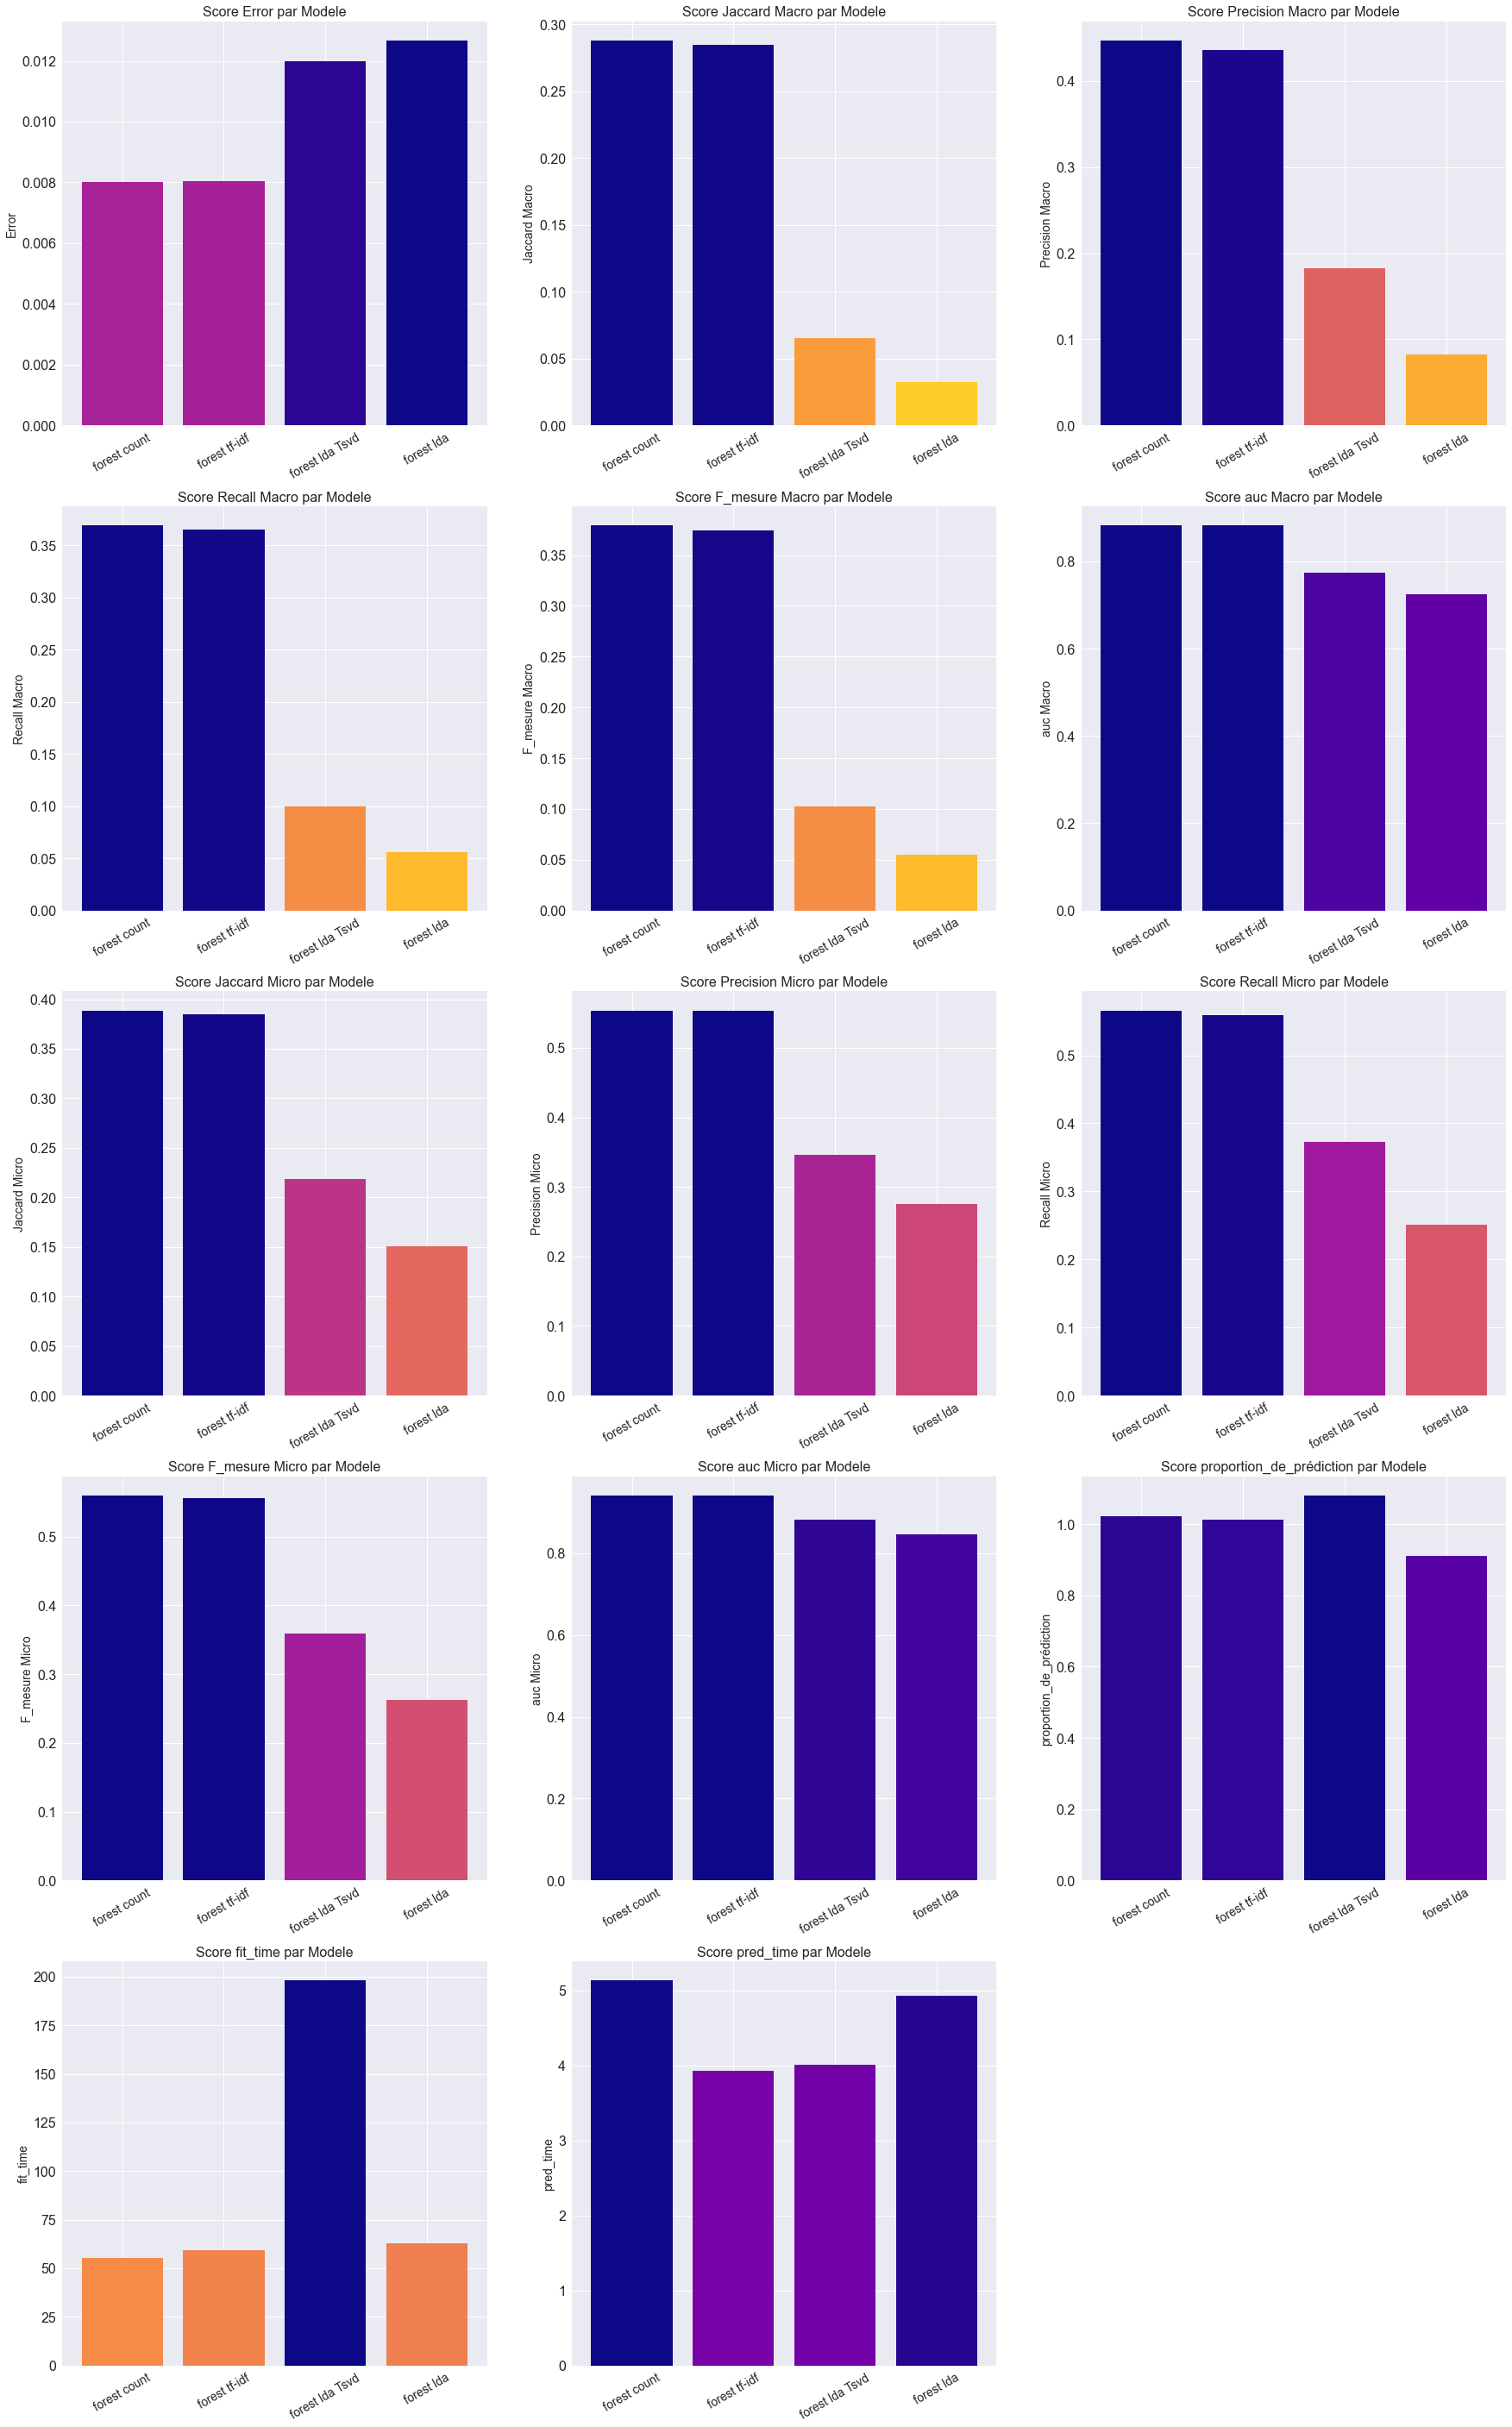

In [21]:
models_data.plot_perf(['Error', 'Jaccard Macro', 'Precision Macro',
                       'Recall Macro', 'F_mesure Macro', 'auc Macro',
                       'Jaccard Micro', 'Precision Micro', 'Recall Micro',
                       'F_mesure Micro', 'auc Micro', 'proportion_de_prédiction',
                       'fit_time', 'pred_time'])

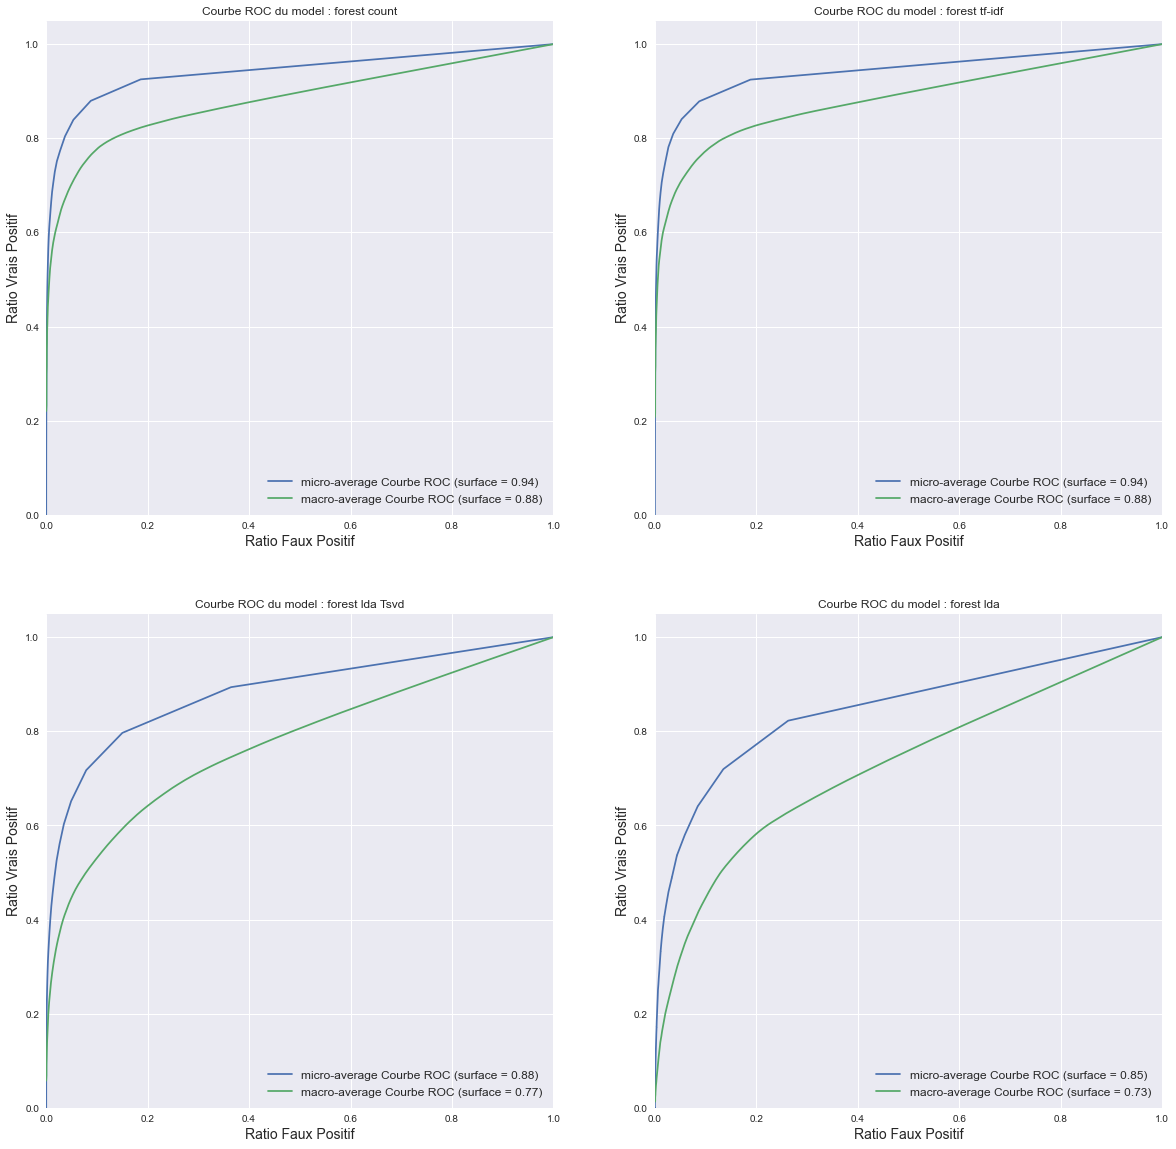

In [22]:
models_data.plot_roc()

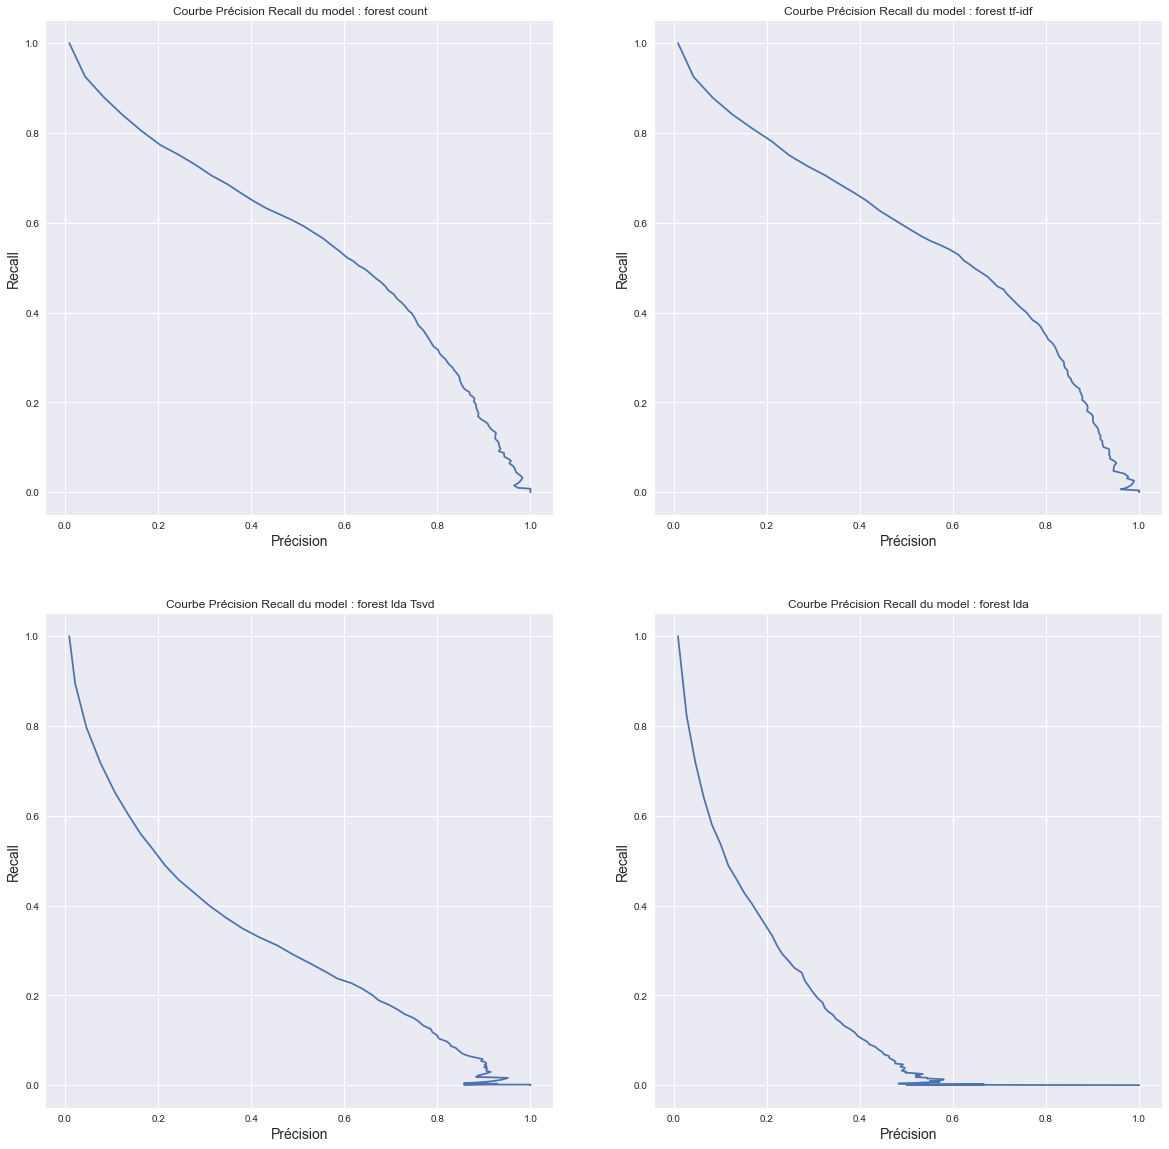

In [23]:
models_data.plot_precision_recall()

### Préparation différents models

In [ ]:
knn = KNeighborsClassifier(n_jobs=-1)
knn_params = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
models.add_model('kNN', knn, knn_params)

decision_tree = DecisionTreeClassifier()
decision_tree_params = {'criterion': ['gini', 'entropy'], 'max_depth': [10, 12, 15, 18, 23, 30, 40, None]}
models.add_model('Decision tree', decision_tree, decision_tree_params)

random_forest = RandomForestClassifier(n_jobs=-1)
random_forest_params = {'n_estimators': np.round(np.logspace(1.2,2.8,8)).astype(int),
                        'bootstrap': [True, False],
                        'max_features': ['sqrt', 'auto', 'log2']}
models.add_model('Random forest', random_forest, random_forest_params)

bagging = BaggingClassifier(n_jobs=-1)
bagging_ovr = OneVsRestClassifier(bagging, n_jobs=-1)
bagging_params = {'estimator__n_estimators': [5, 7, 10, 13, 18]}
models.add_model('Bagging', bagging_ovr, bagging_params)

gradient = GradientBoostingClassifier()
gradient_ovr = OneVsRestClassifier(gradient, n_jobs=-1)
gradient_params = {'estimator__learning_rate': np.logspace(-2.5, 0, 8),
                   'estimator__n_estimators': np.round(np.logspace(1.3,2.5,5)).astype(int)}
models.add_model('Gradient Boosting', gradient_ovr, gradient_params)

naive_bayes = MultinomialNB()
naive_bayes_ovr = OneVsRestClassifier(naive_bayes, n_jobs=-1)
naive_bayes_params = {'estimator__alpha': np.logspace(-4, 1, 40)}
models.add_model('Naive Bayes', naive_bayes_ovr, naive_bayes_params)

linear_svm = LinearSVC()
linear_svm_ovr = OneVsRestClassifier(linear_svm, n_jobs=-1)
linear_svm_params = {'estimator__penalty': ['l1', 'l2'],
                     'estimator__C': [0.1, 1, 10, 100, 1000]}
models.add_model('Linear SVM', linear_svm_ovr, linear_svm_params)

svm = SVC()
svm_ovr = OneVsRestClassifier(svm, n_jobs=-1)
svm_params = {'estimator__kernel': ['rbf', 'poly'],
              'estimator__C': [0.1, 1, 10, 100, 1000],
              'estimator__gamma': [0.1, 1, 10, 100, 'scale', 'auto'],
              'estimator__degree': [2, 3, 4, 5, 6]}
models.add_model('SVM', svm_ovr, svm_params)

random_forest_simple = RandomForestClassifier(n_jobs=-1)
random_forest_chain = ClassifierChain(random_forest_simple)
random_forest_chain_params = {'n_estimators': np.round(np.logspace(1.2,2.8,8)).astype(int),
                               'bootstrap': [True, False],
                               'max_features': ['sqrt', 'auto', 'log2']}
models.add_model('Random Forest Chain', random_forest_chain, random_forest_chain_params)

In [ ]:
models.fit(data_name='tf-idf', cv=5)

## Non-Supervisée

### LDA Gensim

In [13]:
texts = count_vect.inverse_transform(x_train_counts)
dico = Dictionary(texts)
corpus = [dico.doc2bow(text) for text in texts]

In [14]:
texts_test = count_vect.inverse_transform(x_test_counts)
corpus_test = [dico.doc2bow(text) for text in texts_test]

In [41]:
# Build LDA model
lda = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                  id2word=dico,
                                  num_topics=20,
                                  random_state=100,
                                  per_word_topics=True)
# Print Perplexity score
print('Perplexity: ', lda.log_perplexity(corpus))

#Print Coherence Score
coherence_model_lda = CoherenceModel(model=lda, 
                                     texts=texts, 
                                     dictionary=dico, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -8.562087539194787
Coherence Score:  0.32376277382185126


In [42]:
coherence_score = []
time_fit = []
params = range(5,80,5)
for param in tqdm(params):
    start = time.time()
    lda = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                id2word=dico,
                                                num_topics=param,
                                                random_state=24,
                                                per_word_topics=True)
    stop = time.time()
    coherence_model_lda = CoherenceModel(model=lda, 
                                                texts=texts, 
                                                dictionary=dico, 
                                                coherence='c_v')
    coherence_score.append(coherence_model_lda.get_coherence())
    time_fit.append(stop - start)

100%|██████████| 15/15 [11:45<00:00, 47.04s/it]


Text(0, 0.5, "Temps d'execution")

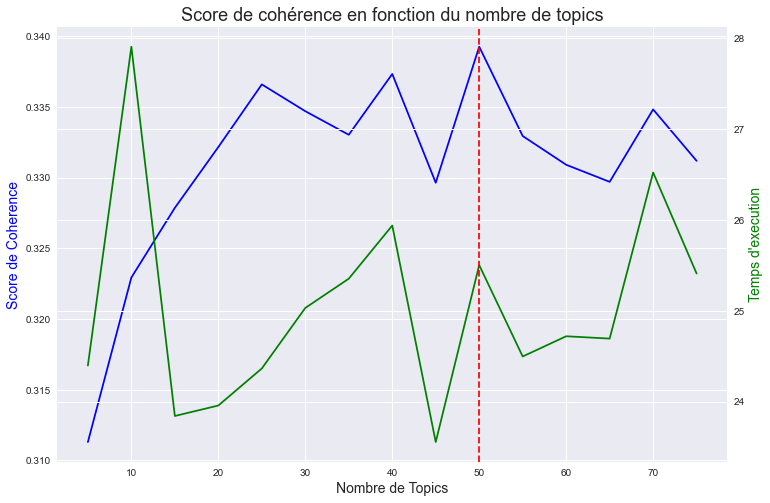

In [45]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()
ax1.plot(params, coherence_score, color="b")
ax2.plot(params, time_fit, color="g")
plt.axvline(50, color="r", linestyle='--', label="Le meileur paramètre est : 20")
plt.title("Score de cohérence en fonction du nombre de topics", fontsize=18)
ax1.set_xlabel("Nombre de Topics", fontsize=14)
ax1.set_ylabel("Score de Coherence", fontsize=14, color="b")
ax2.set_ylabel("Temps d'execution", fontsize=14, color="g")

In [15]:
best_lda = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                  id2word=dico,
                                  num_topics=50)

In [16]:
ldaTags_gensim = np.vectorize(lambda x: dico.get(x))(best_lda.get_topics().argmax(axis=1))
topics_gensim = np.array(best_lda.get_document_topics(corpus, minimum_probability=0))[:,:,1]
topic_matrice_gensim = np.matmul(topics_gensim.T, y_train)
topic_matrice_gensim = topic_matrice_gensim/topic_matrice_gensim.sum(axis=1).reshape(-1,1)
print(topic_matrice_gensim.shape)
y_pred_lda_gensim = np.matmul(np.array(best_lda.get_document_topics(corpus_test, minimum_probability=0))[:,:,1], topic_matrice_gensim)

(50, 606)


In [17]:
models.add_prediction('lda gensim', y_pred_lda_gensim)
models.compute_perf('lda gensim')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn

In [50]:
gensimvis.prepare(best_lda, corpus, dico)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16     0.013126 -0.013736       1        1  2.932460
12    -0.038655 -0.005049       2        1  2.883145
18     0.025539  0.011762       3        1  2.805847
5     -0.014197 -0.002962       4        1  2.610633
41    -0.000627 -0.006281       5        1  2.523405
44    -0.016494 -0.011753       6        1  2.513991
37     0.015364  0.017195       7        1  2.458780
31     0.024530 -0.006200       8        1  2.431086
0      0.016595 -0.001721       9        1  2.377165
24     0.025861 -0.003548      10        1  2.255980
10    -0.003202  0.016077      11        1  2.206103
3     -0.025574  0.001510      12        1  2.200710
25    -0.001570  0.001570      13        1  2.189597
48     0.009006 -0.005102      14        1  2.173623
4      0.003958  0.001084      15        1  2.138118
7     -0.002122 -0.002968      16        1  2.131539
42    -0.007186 -0.010414      17        1  2.121700
27    -0.015615  0.005606      18        1  2.117270
29     0.020074  0.001635      19        1  2.099851
43     0.011485  0.012134      20        1  2.092638
36     0.044204 -0.055148      21        1  2.075401
45    -0.019906 -0.003902      22        1  2.061237
23     0.000533  0.004593      23        1  2.051648
8      0.005042  0.010033      24        1  2.036195
17     0.013821 -0.006218      25        1  2.031836
33     0.011975  0.007933      26        1  2.008187
30     0.006714  0.005985      27        1  1.999721
1     -0.001032 -0.007980      28        1  1.929248
40     0.009881 -0.007703      29        1  1.900391
21    -0.009482 -0.010233      30        1  1.860754
6     -0.003386  0.010879      31        1  1.842735
2      0.009750  0.000115      32        1  1.813685
46     0.006300 -0.014535      33        1  1.809826
9     -0.006984 -0.021144      34        1  1.804781
22    -0.003198 -0.022405      35        1  1.791292
26    -0.007367  0.013863      36        1  1.788285
20     0.006099  0.008691      37        1  1.742644
49    -0.003504 -0.006882      38        1  1.719737
14    -0.019090  0.013697      39        1  1.708259
38    -0.017793 -0.022752      40        1  1.644524
39    -0.063306 -0.016031      41        1  1.618029
11     0.006783  0.011941      42        1  1.608349
28     0.009055  0.007563      43        1  1.578177
35    -0.019055 -0.016348      44        1  1.564023
13    -0.005244  0.037136      45        1  1.533395
34     0.001621  0.001094      46        1  1.512758
47    -0.002646 -0.017785      47        1  1.497326
19     0.001729 -0.005024      48        1  1.430154
32     0.028480  0.044752      49        1  1.410570
15    -0.020288  0.056976      50        1  1.363190, topic_info=             Term         Freq        Total Category  logprob  loglift
217        create  7503.000000  7503.000000  Default  30.0000  30.0000
134       working  9231.000000  9231.000000  Default  29.0000  29.0000
10       database  4661.000000  4661.000000  Default  28.0000  28.0000
223         image  4661.000000  4661.000000  Default  27.0000  27.0000
182           don  8732.000000  8732.000000  Default  26.0000  26.0000
131          time  8314.000000  8314.000000  Default  25.0000  25.0000
132         value  4904.000000  4904.000000  Default  24.0000  24.0000
1119        table  5365.000000  5365.000000  Default  23.0000  23.0000
176           set  7717.000000  7717.000000  Default  22.0000  22.0000
365       project  5280.000000  5280.000000  Default  21.0000  21.0000
135           app  6840.000000  6840.000000  Default  20.0000  20.0000
91         object  6095.000000  6095.000000  Default  19.0000  19.0000
750    javascript  3432.000000  3432.000000  Default  18.0000  18.0000
597          fine  5667.000000  5667.000000  Default  17.0000  17.0000
81          array  4197.000000  4197.000000  Default  16.0000  16.0000
158         class  6931.000000  6931.000000  Default  15.0000  15

### LDA Sklearn

In [19]:
lda = LatentDirichletAllocation(
    n_components=100, 
    n_jobs=-1)
lda.fit(x_train_counts)
topic_matrice = np.matmul(lda.transform(x_train_counts).T, y_train)
topic_matrice = topic_matrice/topic_matrice.sum(axis=1).reshape(-1,1)
print(topic_matrice.shape)
y_pred_lda_sklearn_100 = np.matmul(lda.transform(x_test_counts), topic_matrice)
models.add_prediction('LDA Sklearn 100 topic', y_pred_lda_sklearn_100)

In [20]:
lda = LatentDirichletAllocation(
    n_components=200, 
    n_jobs=-1)
lda.fit(x_train_counts)
topic_matrice = np.matmul(lda.transform(x_train_counts).T, y_train)
topic_matrice = topic_matrice/topic_matrice.sum(axis=1).reshape(-1,1)
print(topic_matrice.shape)
y_pred_lda_sklearn_200 = np.matmul(lda.transform(x_test_counts), topic_matrice)
models.add_prediction('LDA Sklearn 200 topic', y_pred_lda_sklearn_200)

(50, 606)


In [18]:
lda = LatentDirichletAllocation(
    n_components=50, 
    n_jobs=-1)
lda.fit(x_train_counts)
ldaTags = np.vectorize(lambda x: vocabulary[x])(lda.components_.argmax(axis=1))
topic_matrice = np.matmul(lda.transform(x_train_counts).T, y_train)
topic_matrice = topic_matrice/topic_matrice.sum(axis=1).reshape(-1,1)
print(topic_matrice.shape)
y_pred_lda_sklearn = np.matmul(lda.transform(x_test_counts), topic_matrice)
models.add_prediction('LDA Sklearn', y_pred_lda_sklearn)
models.compute_perf('LDA Sklearn')

LatentDirichletAllocation(n_components=50, n_jobs=-1)

In [21]:
models.compute_perf('LDA Sklearn')
models.compute_perf('LDA Sklearn 100 topic')
models.compute_perf('LDA Sklearn 200 topic')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn

In [62]:
LDAsklearn.prepare(lda, x_train_counts, count_vect)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
12     0.031690  0.230258       1        1  4.277752
38    -0.007484 -0.087700       2        1  3.687423
15     0.149719 -0.043991       3        1  3.062370
45     0.099999 -0.119513       4        1  3.042350
44    -0.009499  0.174352       5        1  2.925088
14    -0.097507 -0.050675       6        1  2.853304
3      0.082322 -0.034447       7        1  2.686817
39    -0.065980 -0.046310       8        1  2.647409
49    -0.080766 -0.094729       9        1  2.631120
31    -0.150112 -0.051040      10        1  2.611232
27     0.194741 -0.036581      11        1  2.473002
34    -0.028093  0.140971      12        1  2.457922
7     -0.148823  0.074416      13        1  2.407051
16    -0.111734  0.107783      14        1  2.400522
20    -0.072254  0.087772      15        1  2.398165
43    -0.091059  0.002860      16        1  2.302321
35     0.052230  0.142225      17        1  2.279413
11    -0.095344 -0.054594      18        1  2.266033
21    -0.008171 -0.137741      19        1  2.240812
13     0.199951  0.019185      20        1  2.162016
29    -0.154767 -0.030220      21        1  2.142186
8      0.085857 -0.093174      22        1  2.132972
48     0.182580 -0.075573      23        1  2.100782
17     0.187167 -0.062439      24        1  2.017260
36    -0.166363  0.060989      25        1  1.919404
2      0.121496  0.076590      26        1  1.876002
23     0.187522 -0.056869      27        1  1.828642
37    -0.124744 -0.021466      28        1  1.806487
32     0.031981 -0.092216      29        1  1.759562
9      0.074957 -0.077050      30        1  1.725433
18     0.068009 -0.012196      31        1  1.667128
22    -0.117519  0.004903      32        1  1.650070
30     0.067266  0.103568      33        1  1.626754
0     -0.095082 -0.121326      34        1  1.577514
47    -0.103810 -0.059391      35        1  1.486897
19     0.154436 -0.027900      36        1  1.427474
41     0.134832 -0.019226      37        1  1.416600
6      0.039763  0.085699      38        1  1.415028
10    -0.139234 -0.102209      39        1  1.369724
4      0.016758  0.091967      40        1  1.336555
26     0.034520  0.151764      41        1  1.331316
33     0.003403  0.020584      42        1  1.323631
1     -0.035823  0.085027      43        1  1.310360
46    -0.129695 -0.061072      44        1  1.259710
42    -0.010354 -0.003530      45        1  1.238532
28     0.080958  0.090114      46        1  1.207607
25    -0.106011 -0.048520      47        1  1.192398
40    -0.048326  0.040629      48        1  1.127142
24    -0.065113 -0.081619      49        1  1.048520
5     -0.018490  0.011664      50        1  0.866183, topic_info=           Term          Freq         Total Category  logprob  loglift
11         list  10210.000000  10210.000000  Default  30.0000  30.0000
15        array   9490.000000   9490.000000  Default  29.0000  29.0000
2         table  12079.000000  12079.000000  Default  28.0000  28.0000
6        object  11633.000000  11633.000000  Default  27.0000  27.0000
0         class  14102.000000  14102.000000  Default  26.0000  26.0000
5         image  11568.000000  11568.000000  Default  25.0000  25.0000
17       button   8908.000000   8908.000000  Default  24.0000  24.0000
13       string  10087.000000  10087.000000  Default  23.0000  23.0000
24         view   8056.000000   8056.000000  Default  22.0000  22.0000
33         form   7351.000000   7351.000000  Default  21.0000  21.0000
19       column   8610.000000   8610.000000  Default  20.0000  20.0000
27     database   7991.000000   7991.000000  Default  19.0000  19.0000
30     variable   7389.000000   7389.000000  Default  18.0000  18.0000
29        query   7507.000000   7507.000000  Default  17.0000  17.0000
42      android   6503.000000   6503.000000  Default  16.0000  16.0000
21         type   8548.000000   8548.000000  Default  15.0000  15

### NMF Sklearn

In [23]:
nmf = NMF(n_components=100)
nmf.fit(x_train_counts)
topic_matrice_nmf = np.matmul(nmf.transform(x_train_counts).T, y_train)
topic_matrice_nmf = topic_matrice_nmf/topic_matrice_nmf.sum(axis=1).reshape(-1,1)
print(topic_matrice_nmf.shape)
y_pred_nmf_100 = np.matmul(nmf.transform(x_test_counts), topic_matrice_nmf)
models.add_prediction('NMF Sklearn 100', y_pred_nmf_100)

In [24]:
nmf = NMF(n_components=50)
nmf.fit(x_train_counts)
nmfTags = np.vectorize(lambda x: vocabulary[x])(nmf.components_.argmax(axis=1))
topic_matrice_nmf = np.matmul(nmf.transform(x_train_counts).T, y_train)
topic_matrice_nmf = topic_matrice_nmf/topic_matrice_nmf.sum(axis=1).reshape(-1,1)
print(topic_matrice_nmf.shape)
y_pred_nmf_200 = np.matmul(nmf.transform(x_test_counts), topic_matrice_nmf)
models.add_prediction('NMF Sklearn 200', y_pred_nmf_200)

(50, 606)


In [22]:
nmf = NMF(n_components=50)
nmf.fit(x_train_counts)
nmfTags = np.vectorize(lambda x: vocabulary[x])(nmf.components_.argmax(axis=1))
topic_matrice_nmf = np.matmul(nmf.transform(x_train_counts).T, y_train)
topic_matrice_nmf = topic_matrice_nmf/topic_matrice_nmf.sum(axis=1).reshape(-1,1)
print(topic_matrice_nmf.shape)
y_pred_nmf = np.matmul(nmf.transform(x_test_counts), topic_matrice_nmf)
models.add_prediction('NMF Sklearn', y_pred_nmf)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(n_components=50, random_state=129)

In [25]:

models.compute_perf('NMF Sklearn')
models.compute_perf('NMF Sklearn 100 topic')
models.compute_perf('NMF Sklearn 200 topic')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn

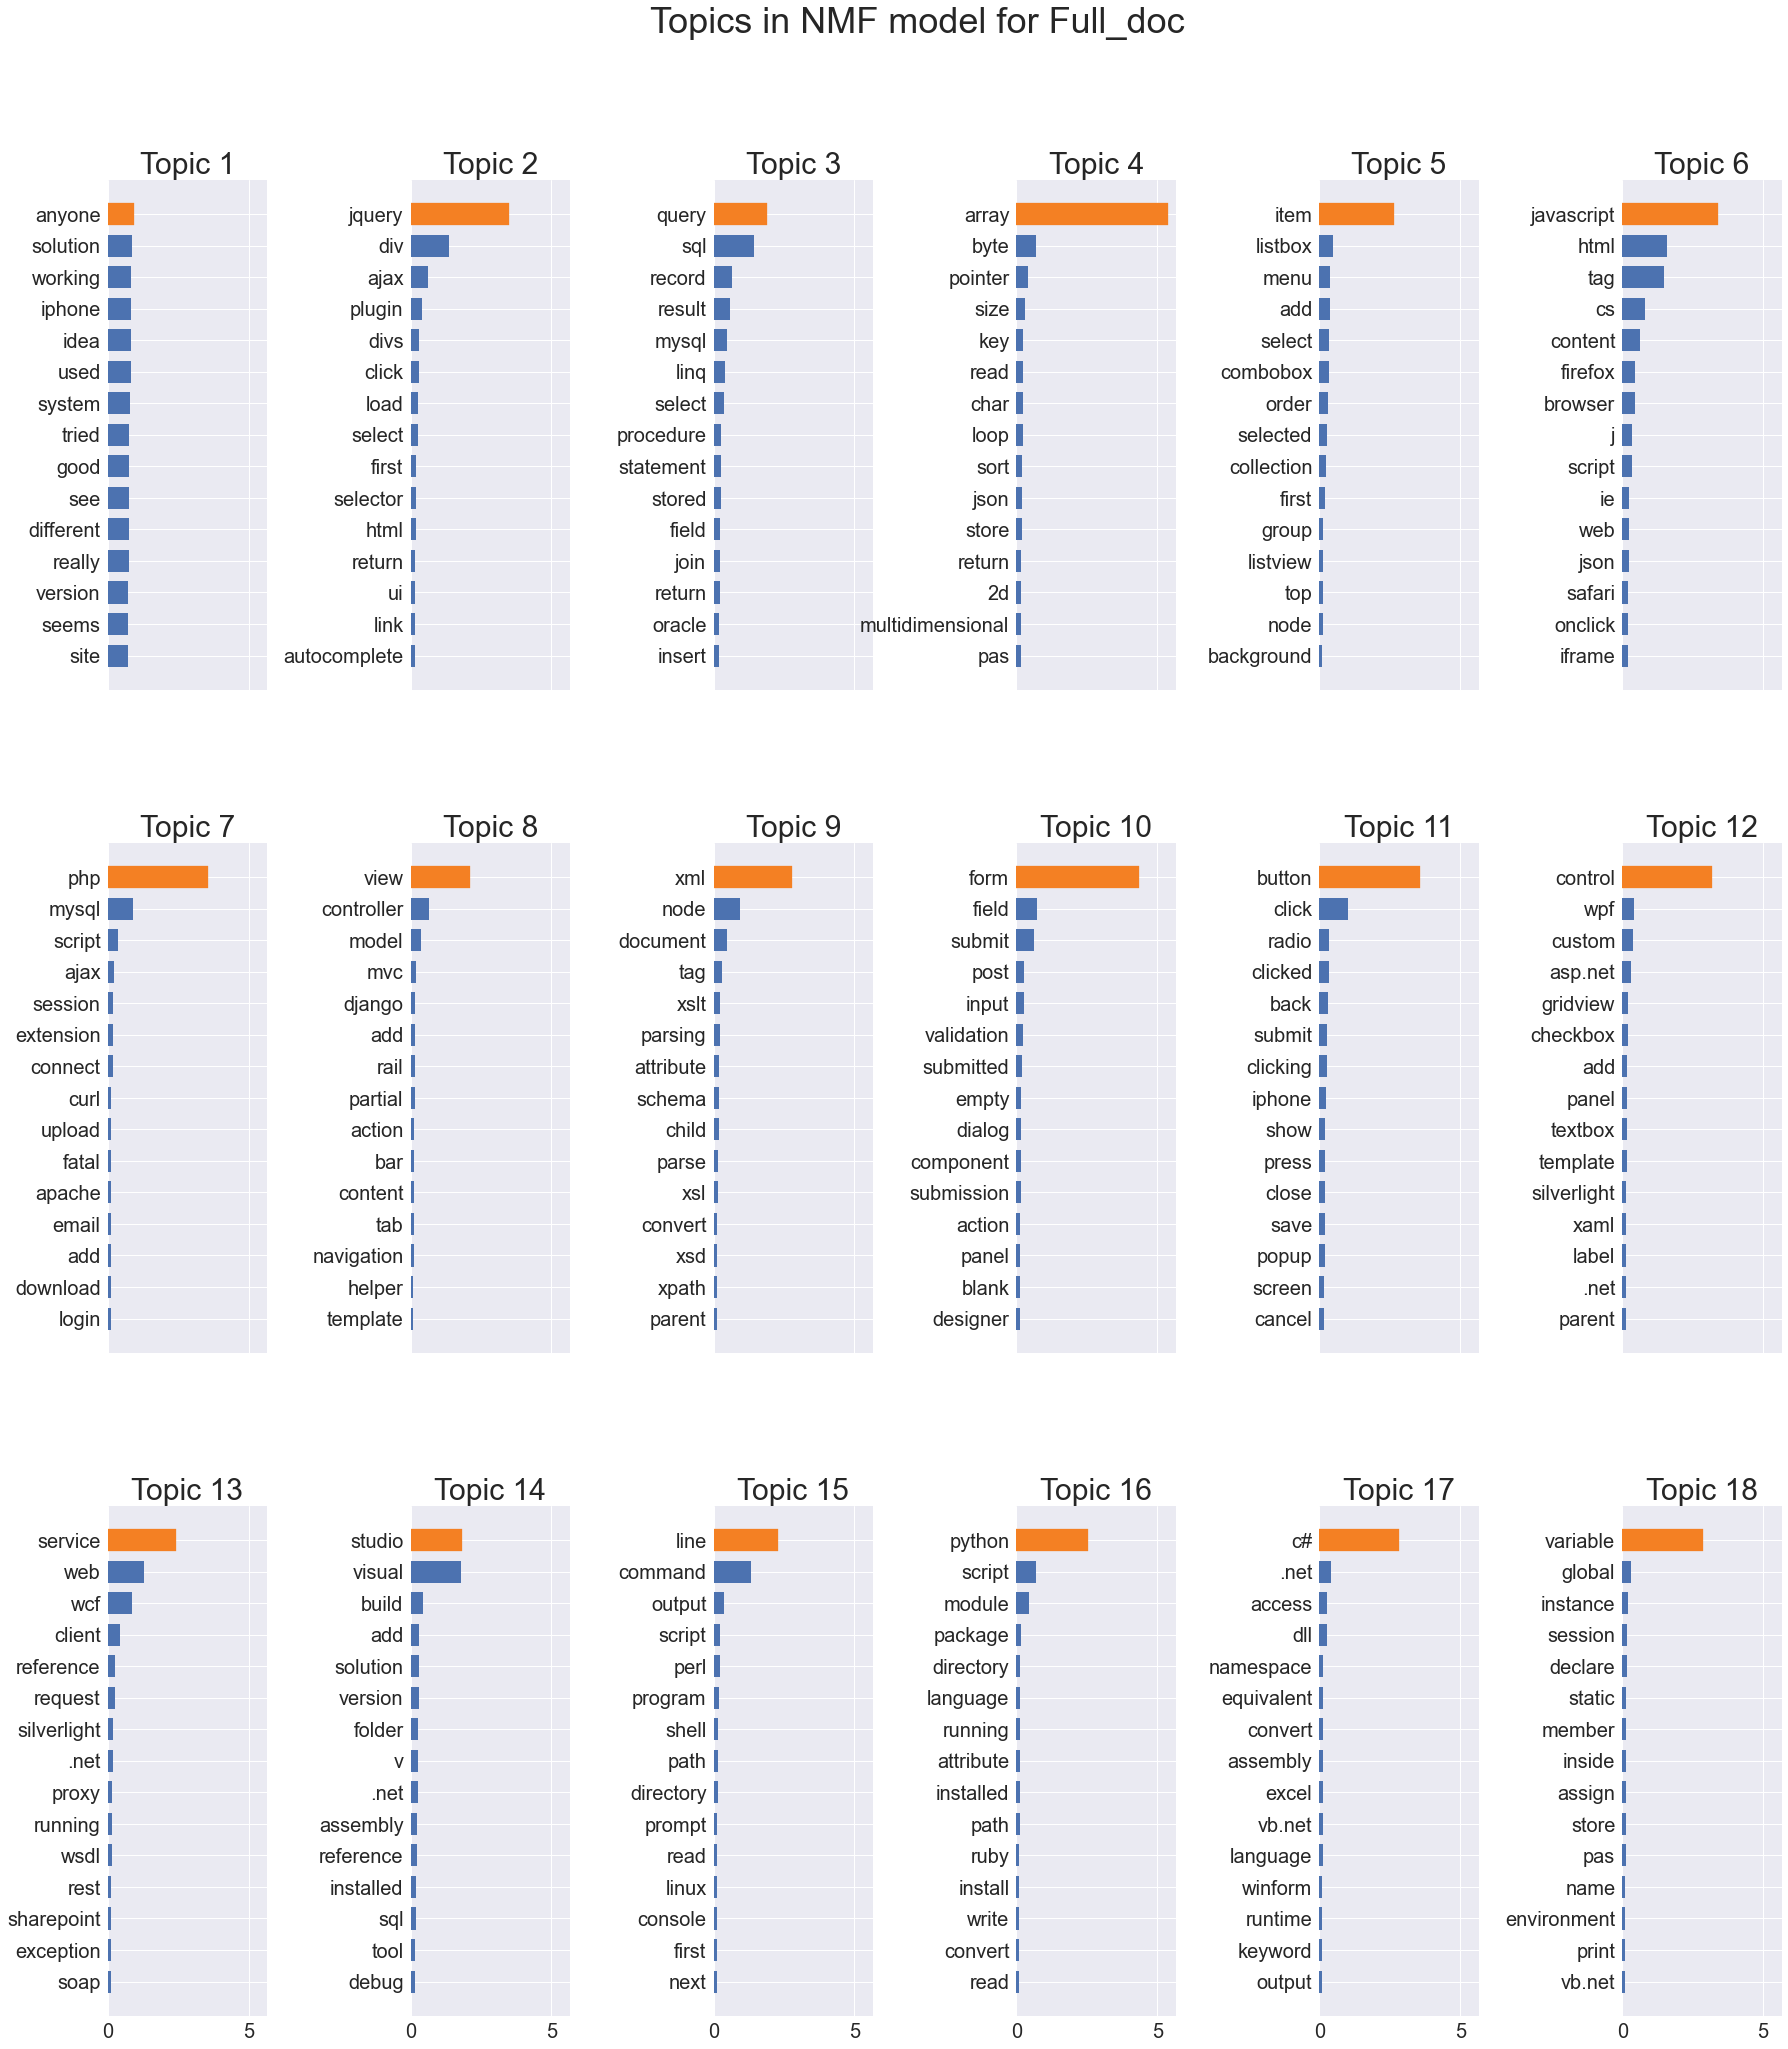

In [ ]:
# Initializing the NMF
full_nmf = NMF(n_components=30, init="nndsvda", random_state=129)

# Fit NMF on Body vectorized
full_nmf.fit(x_train_tfidf)

# Plot the 12 first topics
ff_feature_names = count_vect.get_feature_names_out()
plot_top_words(full_nmf, ff_feature_names, 15, 3,
               'Topics in NMF model for Full_doc')

## Selection et Visualisation

In [13]:
models.models

,grid_params,best_params,data_use,model,confusion_matrice,error,Precision,Recall,F_mesure,proportion_de_prédiction,auc_micro,auc_macro,fit_time,pred_time,y_pred,params
name,,,,,,,,,,,,,,,,
forest,None,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",tf-idf,"(DecisionTreeClassifier(max_features='auto', r...","[[1974.045, 7.97], [7.98, 10.005]]",0.007975,0.556297,0.556606,0.556452,1.000556,0.941956,0.881368,47.160912,4.056153,"[[0.01, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0....","{'fpr': {0: [0.0, 0.0, 0.0005015045135406219, ..."
forest lda Tsvd,None,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",Tsvd lda,"(DecisionTreeClassifier(max_features='auto', r...","[[1968.9, 11.245], [13.125, 6.73]]",0.012185,0.338957,0.374409,0.355802,1.10459,0.889052,0.790268,198.838325,4.229688,"[[0.01, 0.01, 0.0, 0.02, 0.0, 0.0, 0.0, 0.05, ...","{'fpr': {0: [0.0, 0.0, 0.0005015045135406219, ..."
forest lda,None,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",lda,"(DecisionTreeClassifier(max_features='auto', r...","[[1969.62, 13.35], [12.405, 4.625]]",0.012878,0.27158,0.257302,0.264248,0.947427,0.84558,0.717499,54.88008,4.038202,"[[0.0, 0.0, 0.0, 0.06, 0.0, 0.0, 0.01, 0.01, 0...","{'fpr': {0: [0.0, 0.0005015045135406219, 0.001..."


In [136]:
import ray

C:\Users\Jayma\AppData\Local\Temp\ipykernel_44916\2779353090.py:179: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(Rotation=30, fontsize=14)


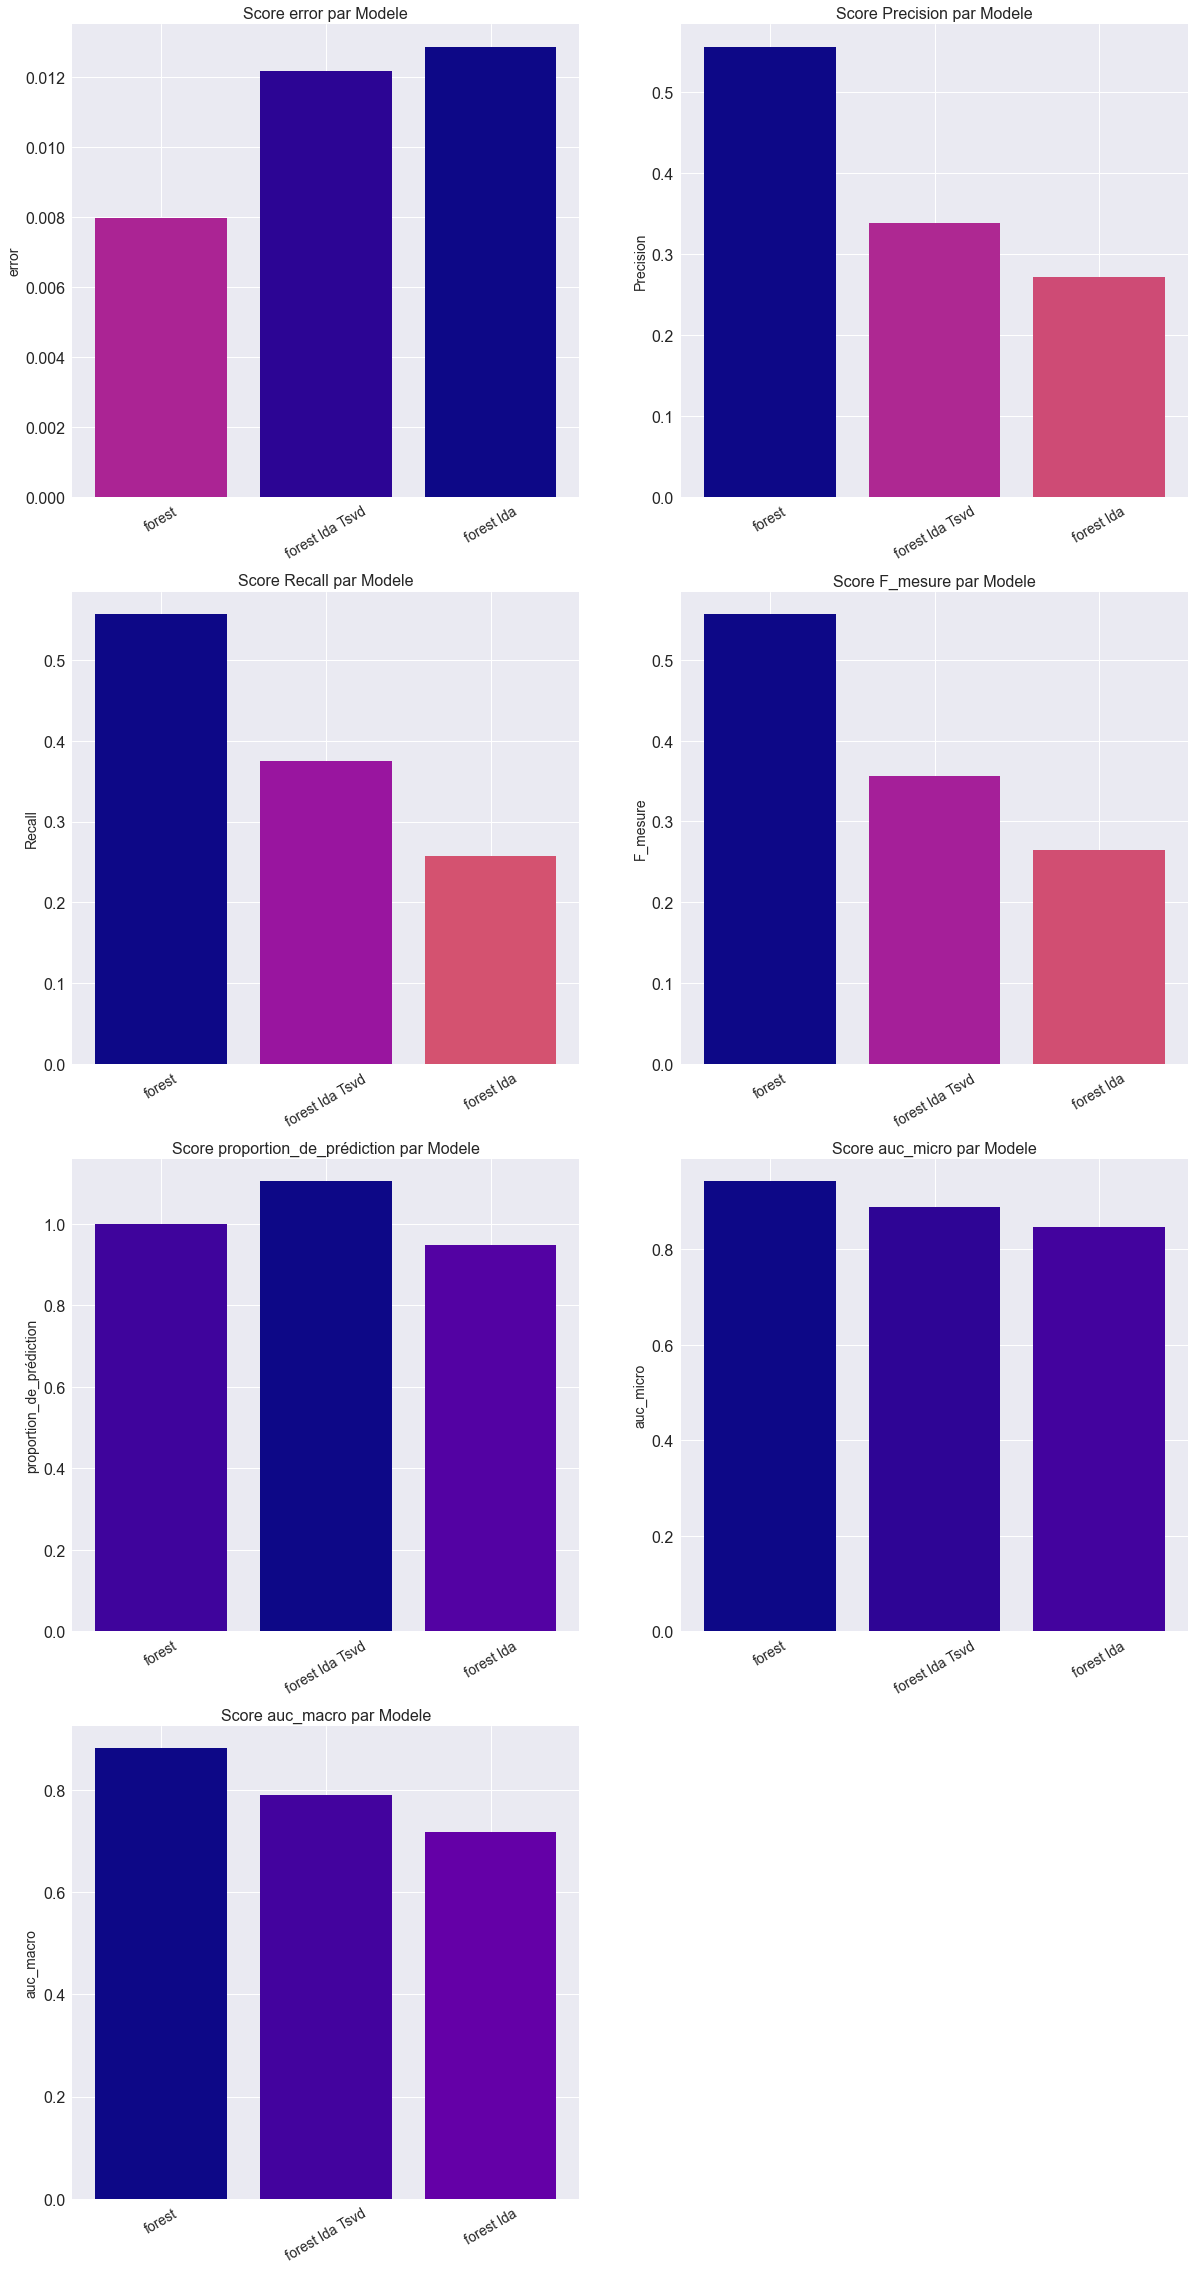

In [14]:
models.plot_perf()

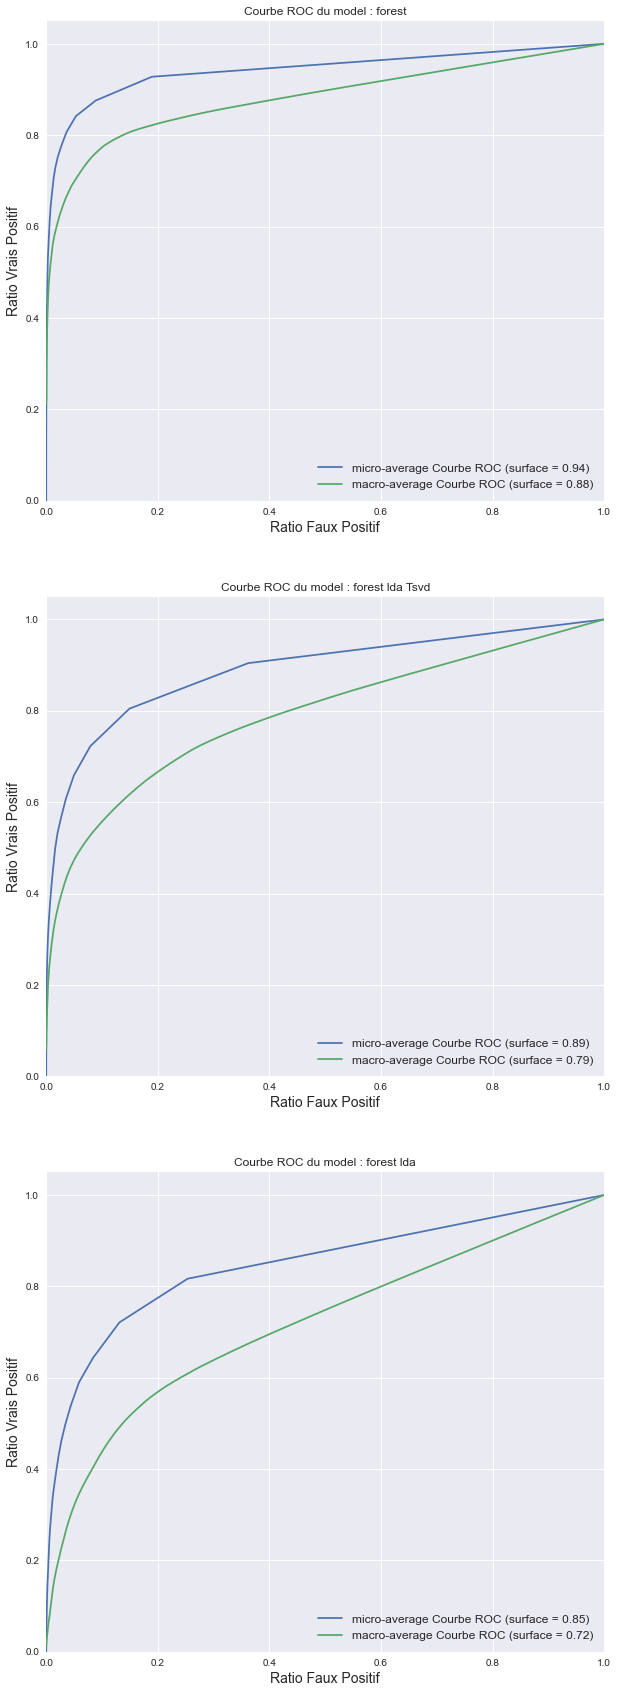

In [16]:
models.plot_roc()

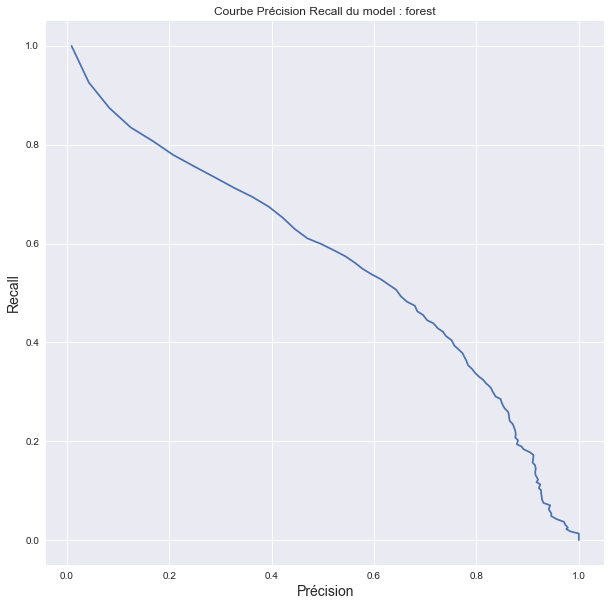

In [15]:
models.plot_precision_recall()